In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.molSize = 300,200
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.useBWAtomPalette()

In [2]:
def atom2bond(mol, atom_begin, atom_end) -> int:
    """返回两个原子之间的键所引
 
    :param mol: rdkit.Chem.rdchem.Mol, 需要处理的分子
    :param atom_begin: int, 起始原子
    :param atom_end: int, 结束原子
    :return: int, 键索引
    """

    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() == atom_begin and bond.GetEndAtomIdx() == atom_end:
            return bond.GetIdx()
        if bond.GetBeginAtomIdx() == atom_end and bond.GetEndAtomIdx() == atom_begin:
            return bond.GetIdx()
    return None

In [3]:
def get_substructure_smiles(mol, root_atom, radius) -> str:
    """返回子结构的SMILES字符串
 
    :param mol: rdkit.Chem.rdchem.Mol, 需要处理的分子
    :param root_atom: int, 中心原子索引
    :param radius: int, 子结构半径
    :return: str, 子结构的SMILES字符串
    """
    # 更新
    # 现在不仅需要输出SMILES字符串，还需要输出子结构中原子和键的索引

    atom_list = []
    bond_list = []
    if radius > 0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, root_atom)
        atom_map = {}
        _ = Chem.PathToSubmol(mol, env, atomMap=atom_map)
        # 获取子结构原子索引和键索引
        for atom in atom_map:
            atom_list.append(atom)

        for atom in atom_list:
            for bond in mol.GetBonds():
                if bond.GetBeginAtomIdx() == atom and bond.GetEndAtomIdx() in atom_list:
                    bond_list.append(bond.GetIdx())

        substructure_smiles = Chem.MolFragmentToSmiles(mol, atomsToUse=atom_map, allBondsExplicit=True, allHsExplicit=True)
    else:
        atom_list.append(root_atom)
        substructure_smiles = Chem.MolFragmentToSmiles(mol, atomsToUse=(root_atom, ), allBondsExplicit=True, allHsExplicit=True)
    
    return substructure_smiles, atom_list, bond_list

In [4]:
def random_SMILES(mol) -> str:
    """ 生成当前分子的随机SMILES字符串
    
    :param mol: rdkit.Chem.rdchem.Mol, 需要处理的分子
    :return: str, 随机SMILES字符串
    """
    random_smi = Chem.MolToSmiles(mol,doRandom=True,canonical=False)
    return random_smi

In [5]:
def upgrade_structure(mol, root_atom, radius) -> str:
    """ 子结构的父结构SMILES
    
    :param mol: rdkit.Chem.rdchem.Mol, 需要处理的分子
    :param root_atom: int, 中心原子索引
    :param radius: int, 子结构半径
    :return: str, 父结构SMILES
    """
    
    smi = get_substructure_smiles(mol, root_atom, radius + 1)
    return smi

In [6]:
def is_aromatic(mol, atom_list) -> bool:
    """ 判断子结构里是否有芳香原子

    :param mol: rdkit.Chem.rdchem.Mol, 分子对象
    :param atom_list: list, 子结构原子索引
    :return: bool, 有无芳香原子
    """
    
    for atom in atom_list:
        if mol.GetAtomWithIdx(atom).GetIsAromatic():
            return True
    return False

In [7]:
def is_valid_smiles(smiles) -> bool:
    """ 判断一个SMILES字符串是否是合法分子

    :param smiles: str, 需要处理的分子
    :return: bool, 是否是合法分子
    """
    try:
        molecule = Chem.MolFromSmiles(smiles)
        if molecule is None:
            return False
        else:
            return True
    except Exception:
        return False

In [8]:
def is_repeat_smiles(smiles, final_sub) -> bool:
    """ 判断一个子结构的SMILES字符串是否已经出现过/已选择
    
    :param smiles: str, 子结构的SMILES字符串
    :param final_sub: list, 已选子结构信息
    :return: bool, 是否重复
    """
    
    smiles_list = []
    for sub in final_sub:
        smiles_list.append(sub[0])

    if smiles in smiles_list:
        return True
    else:
        return False

In [2]:
def complete(mol, root_atom, radius) -> tuple:
    """ 将一个非法子结构补全(修复未闭合的苯环)

    :param mol: rdkit.Chem.rdchem.Mol, 分子对象
    :param root_atom: int, 中心原子索引
    :param radius: int, 当前子结构半径
    :return: tuple, 补全后的子结构信息
    """
    
    if radius > 0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, root_atom)
        atom_map = {}
        _ = Chem.PathToSubmol(mol, env, atomMap=atom_map)
    else:
        atom_map = (root_atom,)


    atom_to_add = set() # set of atom index
    for atom in atom_map: # collect current substructure atom index
        atom_to_add.add(atom)
    
    ri = mol.GetRingInfo()
    for atom in atom_map:
        for ring in ri.AtomRings():
            if atom in ring and mol.GetAtomWithIdx(atom).GetIsAromatic():
                for r in ring:
                    atom_to_add.add(r)
    
    complete_sub = Chem.MolFragmentToSmiles(mol, atom_to_add, allBondsExplicit=True, allHsExplicit=True)
    atom_list = list(atom_to_add)
    bond_list = []
    for atom in atom_list:
        for bond in mol.GetBonds():
            if bond.GetBeginAtomIdx() == atom and bond.GetEndAtomIdx() in atom_list:
                bond_list.append(bond.GetIdx())

    # check if the substructure is valid
    if not is_valid_smiles(complete_sub):
        print('Warning! Error happen, complete sub is still invalid:', Chem.MolToSmiles(mol))
        return None, [], []

    return complete_sub, atom_list, bond_list

In [10]:
def upgrade_structure(mol, root_atom, radius,) -> tuple:
    
    super_smiles, atom_list, bond_list = get_substructure_smiles(mol, root_atom, radius + 1)
    return super_smiles, atom_list, bond_list

---

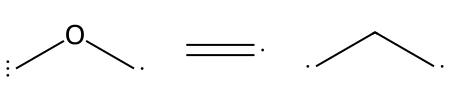

In [18]:
# 并列生成子结构


# mol2 = Chem.MolFromSmiles('[C]-[O]-[CH2]')
# mol3 = Chem.MolFromSmiles('[CH2]=[CH]')
# mol4 = Chem.MolFromSmiles('[CH2]-[CH2]-[CH2]')
# ms = [mol2, mol3, mol4]

# Draw.MolsToGridImage(ms, molsPerRow=3, subImgSize=(150,100), useSVG=True)

1. 对象化SMILES
2. 获取子结构集合（打印输出）
3. 使用特征重要性进行排序（打印输出）
4. 子结构筛选算法
5. 打印最终集合

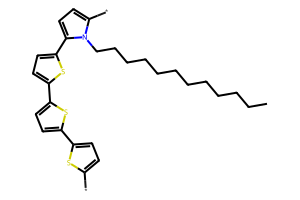

In [18]:
# 改变这里的分子 Change the molecule here
mol = Chem.MolFromSmiles('[*]c1ccc(-c2ccc(-c3ccc(-c4ccc([*])n4CCCCCCCCCCCC)s3)s2)s1')
Draw.MolToImage(mol, size=(300,200))

In [19]:
n = 3
radii = 2
size = 2048
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radii,fpSize=size)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitInfoMap()
_ = mfpgen.GetCountFingerprint(mol,additionalOutput=ao)
bitInfo = ao.GetBitInfoMap()

# subStructures[key, root_atom, radius, substructure_smiles, atom_lsit, bond_list]

subStructures = []
for key, value in bitInfo.items():
    root_atom = value[0][0]
    radius = value[0][1]
    substructure_smiles, atom_lsit, bond_list = get_substructure_smiles(mol, root_atom, radius)
    subStructures.append((key, root_atom, radius, substructure_smiles, atom_lsit, bond_list))

In [20]:
for sub in subStructures:
    print("bit key:", sub[0], "ratom:", sub[1], "r:", sub[2], "sub smiles:", sub[3], "atom list:", sub[4], "bond list:", sub[5])

bit key: 62 ratom: 12 r: 1 sub smiles: [c]-[c](:[cH]):[s] atom list: [11, 12, 13, 31] bond list: [11, 12, 30]
bit key: 80 ratom: 19 r: 0 sub smiles: [CH2] atom list: [19] bond list: []
bit key: 162 ratom: 33 r: 1 sub smiles: [c]:[s]:[c] atom list: [1, 4, 33] bond list: [32, 33]
bit key: 182 ratom: 16 r: 1 sub smiles: [*]-[c](:[cH]):[n] atom list: [15, 16, 17, 18] bond list: [15, 16, 17]
bit key: 226 ratom: 0 r: 0 sub smiles: [*] atom list: [0] bond list: []
bit key: 229 ratom: 12 r: 2 sub smiles: [cH]:[c](:[n])-[c]1:[cH]:[cH]:[c]:[s]:1 atom list: [9, 10, 11, 12, 13, 14, 18, 31] bond list: [9, 10, 11, 12, 30, 13, 36, 35]
bit key: 294 ratom: 30 r: 1 sub smiles: [CH2]-[CH3] atom list: [29, 30] bond list: [29]
bit key: 355 ratom: 13 r: 2 sub smiles: [cH]:[c](:[s])-[c]1:[cH]:[cH]:[c]:[n]:1-[CH2] atom list: [11, 12, 13, 14, 15, 16, 18, 19, 31] bond list: [11, 12, 30, 13, 14, 15, 17, 18, 36]
bit key: 372 ratom: 14 r: 2 sub smiles: [c]-[c]1:[cH]:[cH]:[c]:[n]:1 atom list: [12, 13, 14, 15, 16, 1

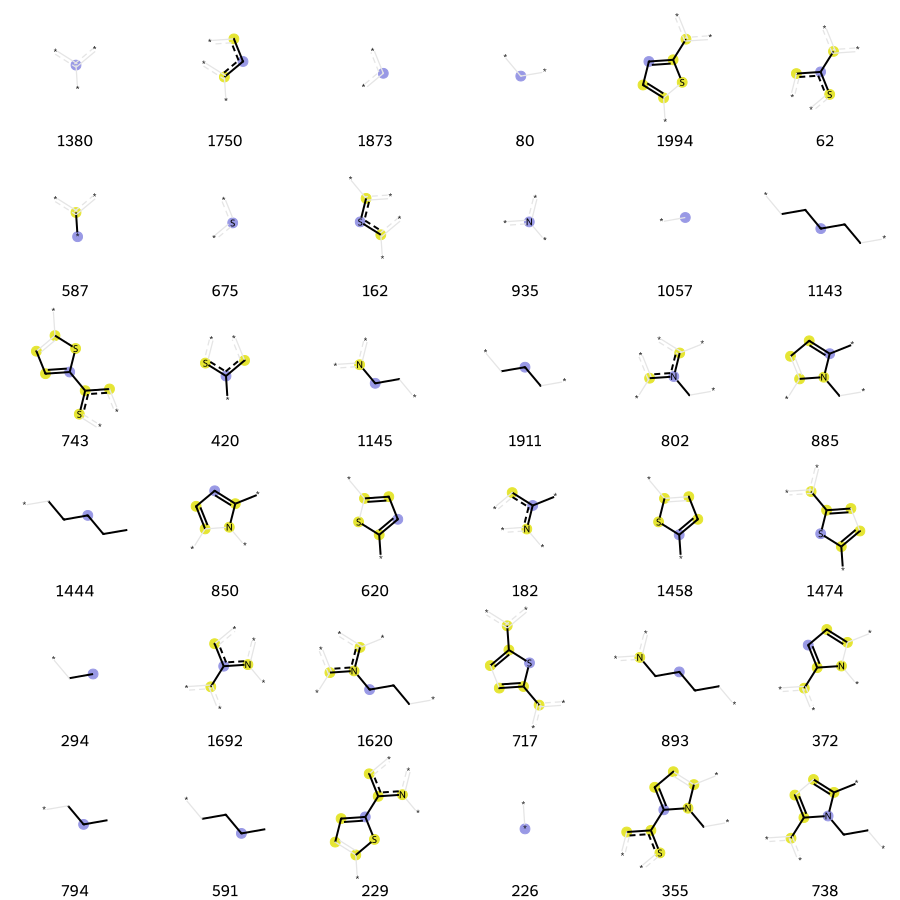

In [21]:
IPythonConsole.drawOptions.addAtomIndices = False

feature_importances = pd.read_csv('C:/Users/Blue/Desktop/数据科学研究组/Experiments/RF_SEMPNN/feature_importance/egb_2_2048_42.csv')

subStructures = sorted(subStructures, key=lambda x: feature_importances.loc[feature_importances['bit'] == x[0], 'importance'].values[0], reverse=True)

list_bits = []
legends = []

for x in subStructures:
    list_bits.append((mol, x[0], ao.GetBitInfoMap()))
    legends.append(str(x[0]))
Draw.DrawMorganBits(list_bits, molsPerRow=6, legends=legends)

In [22]:
for sub in subStructures:
    print("bit key:", sub[0], "ratom:", sub[1], "r:", sub[2], "sub smiles:", sub[3], "atom list:", sub[4], "bond list:", sub[5])

bit key: 1380 ratom: 1 r: 0 sub smiles: [c] atom list: [1] bond list: []
bit key: 1750 ratom: 2 r: 1 sub smiles: [c]:[cH]:[cH] atom list: [1, 2, 3] bond list: [1, 2]
bit key: 1873 ratom: 2 r: 0 sub smiles: [cH] atom list: [2] bond list: []
bit key: 80 ratom: 19 r: 0 sub smiles: [CH2] atom list: [19] bond list: []
bit key: 1994 ratom: 11 r: 2 sub smiles: [c]-[c]1:[cH]:[cH]:[c]:[s]:1 atom list: [9, 10, 11, 12, 13, 31] bond list: [9, 10, 11, 12, 30, 35]
bit key: 62 ratom: 12 r: 1 sub smiles: [c]-[c](:[cH]):[s] atom list: [11, 12, 13, 31] bond list: [11, 12, 30]
bit key: 587 ratom: 0 r: 1 sub smiles: [*]-[c] atom list: [0, 1] bond list: [0]
bit key: 675 ratom: 31 r: 0 sub smiles: [s] atom list: [31] bond list: []
bit key: 162 ratom: 33 r: 1 sub smiles: [c]:[s]:[c] atom list: [1, 4, 33] bond list: [32, 33]
bit key: 935 ratom: 18 r: 0 sub smiles: [n] atom list: [18] bond list: []
bit key: 1057 ratom: 30 r: 0 sub smiles: [CH3] atom list: [30] bond list: []
bit key: 1143 ratom: 21 r: 2 sub smi

In [23]:
final_sub = []
i = 0
while i < n:
    if i >= len(subStructures):
        final_sub.append((random_SMILES(mol), [-1], [-1]))
        i += 1
        continue
    
    root_atom = subStructures[i][1]
    radius = subStructures[i][2]
    sub_smiles = subStructures[i][3]
    atom_list = subStructures[i][4]
    bond_list = subStructures[i][5]
    
# ------------------------------------------------
    if sub_smiles == '[CH2]' or sub_smiles == '*':
        super_sub, _, _ = upgrade_structure(mol, root_atom, radius)
        # 这里跳过'[CH2]'的原因还需思考
        if '=' not in super_sub:
            i += 1
            n += 1
            continue
# ------------------------------------------------
    
    if is_aromatic(mol, atom_list):
        complete_sub, atom_list, bond_list = complete(mol, root_atom, radius)
        if complete_sub == None:
            i += 1
            n += 1
            continue
        else:
            if is_repeat_smiles(complete_sub, final_sub):
                n += 1
            else:
                final_sub.append((complete_sub, atom_list, bond_list))
    else:
        if radius > 0:
            if is_repeat_smiles(sub_smiles, final_sub):
                n += 1
            else:
                final_sub.append((sub_smiles, atom_list, bond_list))
        else:
            if 'C' in sub_smiles or 'O' in sub_smiles or 'N' in sub_smiles:
                super_sub, atom_list, bond_list = upgrade_structure(mol, root_atom, radius)
                if is_valid_smiles(super_sub):
                    if is_repeat_smiles(super_sub, final_sub):
                        n += 1
                    else:
                        final_sub.append((super_sub, atom_list, bond_list))
                else:
                    complete_sub, atom_list, bond_list = complete(mol, root_atom, radius+1)
                    if complete_sub == None:
                        i += 1
                        n += 1
                        continue
                    else:
                        if is_repeat_smiles(complete_sub, final_sub):
                            n += 1
                        else:
                            #--------------------------------
                            if is_aromatic(mol, atom_list):
                                n += 1
                            #--------------------------------
                            else:
                                final_sub.append((complete_sub, atom_list, bond_list))
            else:
                final_sub.append((sub_smiles, atom_list, bond_list))
    
    i += 1

Warning! Error happen, complete sub is still invalid: *c1ccc(-c2ccc(-c3ccc(-c4ccc(*)n4CCCCCCCCCCCC)s3)s2)s1
Warning! Error happen, complete sub is still invalid: *c1ccc(-c2ccc(-c3ccc(-c4ccc(*)n4CCCCCCCCCCCC)s3)s2)s1
Warning! Error happen, complete sub is still invalid: *c1ccc(-c2ccc(-c3ccc(-c4ccc(*)n4CCCCCCCCCCCC)s3)s2)s1


[14:09:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[14:09:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[14:09:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


In [24]:
for sub in final_sub:
    print("sub smiles:", sub[0], "atom list:", sub[1], "bond list:", sub[2])

sub smiles: [cH]1:[cH]:[c]:[s]:[c]:1 atom list: [1, 2, 3, 4, 33] bond list: [1, 2, 3, 32, 33]
sub smiles: [*]-[c]1:[cH]:[cH]:[c]:[s]:1 atom list: [0, 1, 2, 3, 4, 33] bond list: [0, 1, 2, 3, 32, 33]
sub smiles: [CH2]-[CH3] atom list: [29, 30] bond list: [29]


---